# Homework 3: Evaluating Generative Models

We are going to practice how to evaluate generative models.
The evaluation method is not limited to diffusion models, in fact, deep generative models such as GAN and Flow use this method widely.

<span style="color:red">It is necessary to have a GPU to complete LAB2.</span><br>
<span style="color:red">Its efficacy will not affect your completion of this lab. Colab free plan also works.</span>

## Install Packages

Install `torch`, `torchvision` and `pytorch_gan_metrics`.

- Colab

    Use system default `torch` and `torchvision` to avoid hardware incompatibility.
    ```
    pip install pytorch_gan_metrics
    ```

- Custom environment (include `conda` users)

    Install all packages from pypi.
    ```
    pip install torch torchvision pytorch_gan_metrics
    ```

In [65]:
from torchvision import transforms, datasets
from IPython.display import display
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import os
from copy import deepcopy
from torchsummary import summary
import torch.utils.data as data
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import einops
from torchvision.utils import save_image,make_grid

In [66]:
BATCH_SIZE = 128
IMG_SIZE = 28
CHANNEL = 1
EPOCH = 200
SIZE = 28
lr = 0.0001
MODEL_DIR = '.\\model_weight\\'
root_train = '.\\train\\'

save_dir = os.path.join(MODEL_DIR)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)


In [67]:
print(torch.__version__)
print(torch.version.cuda)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

1.13.0
11.6


## Building the Diffusion Model

We first need to build the inputs for our model, which are more and more noisy images. Instead of doing this sequentially, we can use the closed form provided in the papers to calculate the image for any of the timesteps individually.

### Key Takeaways:
+ The noise-levels/variances can be pre-computed
+ There are different types of variance schedules
+ We can sample each timestep image independently (Sums of Gaussians is also Gaussian)
+ No model is needed in this forward step

$$
q( x_t | x_0 ) = N( x_t; \sqrt{{\alpha}_t}x_t, (1-{\alpha}_t)I )
$$

In [68]:
# DDPM class
class DDPM(nn.Module):
    def __init__(self, network, n_steps=200, min_beta=10 ** -4, max_beta=0.02, device=None, image_chw=(1, 28, 28)):
        super(DDPM, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.image_chw = image_chw
        self.network = network.to(device)
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(
            device)  # Number of steps is typically in the order of thousands
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

    def forward(self, x0, t, eta=None):
        # Make input image more noisy (we can directly skip to the desired step)
        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t]

        if eta is None:
            eta = torch.randn(n, c, h, w).to(self.device)

        noisy = a_bar.sqrt().reshape(n, 1, 1, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * eta
        return noisy

    def backward(self, x, t):
        # Run each image through the network for each timestep t in the vector t.
        # The network returns its estimation of the noise that was added.
        return self.network(x, t)

## Show Images Functions

In [72]:
def show_tensor_image(image,save,idx=0):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[idx, :, :, :] 
    if save == False:
        #print(str)
        #image = torch.clamp(image, min=-1, max=1)  # clamp [-1, 1]
        plt.imshow(reverse_transforms(image), cmap="gray")
        return image
    else:
        return image
    #plt.show()

def show_forward(ddpm, loader, device):
    # Showing the forward process
    for batch in loader:
        imgs = batch
        num_images = 6
        idx = 0
        plt.figure(figsize=(15,15))
        plt.axis('off')
        for percent in [0.0 ,0.2,0.4, 0.6, 0.8, 1]:
            plt.subplot(1, num_images + 1, idx + 1)
            if percent == 0.0:
                show_tensor_image(imgs,False)
            else:
                show_tensor_image(ddpm(imgs.to(device),
                    [int(percent * ddpm.n_steps) - 1 for _ in range(len(imgs))]).detach().cpu(),False)
            idx += 1
        break
    plt.show()

def generate_new_images(ddpm, n_samples=16, device=None, c=1, h=28, w=28,process=False):
    """Given a DDPM model, a number of samples to be generated and a device, returns some newly generated samples"""
    images = []
    with torch.no_grad():
        if device is None:
            device = ddpm.device
        
        if process == True:
            tmp = torch.zeros((n_samples, c, h, w), dtype=torch.float32).to(device)
            images = tmp.detach().cpu()
        
        # Starting from random noise
        x = torch.randn(n_samples, c, h, w).to(device)
        steps = int(ddpm.n_steps/6)
        #print('steps:', steps)

        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            # Estimating noise to be removed
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            eta_theta = ddpm.backward(x, time_tensor)

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            # Partially denoising the image
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)
            
            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)
                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()

                # Adding some more noise like in Langevin Dynamics fashion
                x = x + sigma_t * z
            if process and (idx ==0 or (idx+1) % steps==0) :
                images=torch.cat((images,x.detach().cpu()),0)
                #images.append(x)
        if process:
            return images
    #print(x.shape)
    return x

### Load Data set and observation

In [71]:
# Load Training Data
from PIL import Image
import glob
train_data = []

transform = transforms.Compose([
    #transforms.Pad(2, fill=0, padding_mode='constant'),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x - 0.5) * 2)
    #transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
])

for im_path in glob.glob(".\\train\\*.png"):
    train_data.append( transform(Image.open(im_path)))
print(len(train_data))


60000


In [75]:
data_loader = DataLoader( train_data, batch_size=BATCH_SIZE, shuffle=True,drop_last=True )

In [76]:
print(train_data[0].shape)# CHW

torch.Size([1, 28, 28])


## Training Model

In [77]:
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.tensor([[i / 10_000 ** (2 * j / d) for j in range(d)] for i in range(n)])
    sin_mask = torch.arange(0, n, 2)

    embedding[sin_mask] = torch.sin(embedding[sin_mask])
    embedding[1 - sin_mask] = torch.cos(embedding[sin_mask])

    return embedding

In [78]:
class Block(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(Block, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.ReLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        if self.normalize:
            out = self.ln(x) 
        else:
            out = x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out

In [93]:
class UNet(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100, image_channels=1):
        super(UNet, self).__init__()
        down_channels = (image_channels,16, 32, 64)
        up_channels = (128 ,64, 32, 16)
        size = (28, 14, 7)
        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # First half
        self.te1 = self._make_te(time_emb_dim, down_channels[0])
        self.b1 = self._make_conv(down_channels[0], down_channels[1] ,down_channels[1], size[0] )
        self.down1 = nn.Conv2d(down_channels[1], down_channels[1], 4, 2, 1)

        self.te2 = self._make_te(time_emb_dim, down_channels[1])
        self.b2 = self._make_conv(down_channels[1], down_channels[2] ,down_channels[2], size[1] )
        self.down2 = nn.Conv2d(down_channels[2], down_channels[2], 4, 2, 1)

        self.te3 = self._make_te(time_emb_dim, down_channels[2])
        self.b3 = self._make_conv(down_channels[2], down_channels[3] ,down_channels[3], size[2] )
        self.down3 = nn.Sequential(
            nn.Conv2d(down_channels[3], down_channels[3], 2, 1),
            nn.ReLU(),
            nn.Conv2d(down_channels[3], down_channels[3], 4, 2, 1)
        )

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, down_channels[3])
        self.b_mid = nn.Sequential(
            Block((down_channels[3], 3, 3), down_channels[3], down_channels[2]),
            Block((down_channels[2], 3, 3), down_channels[2], down_channels[2]),
            Block((down_channels[2], 3, 3), down_channels[2], down_channels[3])
        )

        # Second half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(down_channels[3], down_channels[3], 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(down_channels[3], down_channels[3], 2, 1)
        )
        
        self.te4 = self._make_te(time_emb_dim, up_channels[0])
        self.b4 = self._make_conv(up_channels[0], up_channels[1] ,up_channels[2], size[2] )

        self.up2 = nn.ConvTranspose2d(up_channels[2], up_channels[2], 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, up_channels[1])
        self.b5 = self._make_conv(up_channels[1], up_channels[2] ,up_channels[3], size[1] )
        
        self.up3 = nn.ConvTranspose2d(up_channels[3], up_channels[3], 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, up_channels[2])
        self.b_out = self._make_conv(up_channels[2], up_channels[3] ,up_channels[3], size[0] )
        self.conv_out = nn.Conv2d(up_channels[3], 1, 3, 1, 1)

    def forward(self, x, t):
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (N, 16, 28, 28)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # (N, 32, 14, 14)
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # (N, 64, 7, 7)

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # (N, 64, 3, 3)

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 128, 7, 7)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (N, 32, 7, 7)

        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 64, 14, 14)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (N, 16, 14, 14)

        out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 32, 28, 28)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (N, 1, 28, 28)
        out = self.conv_out(out)
        #print('Network:',out.shape)
        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.ReLU(),
            nn.Linear(dim_out, dim_out)
        )

    def _make_conv(self, in_c, mid_c, out_c, size, normalize=True ):
        return nn.Sequential(
            Block((in_c, size, size), in_c, mid_c),
            Block((mid_c, size, size), mid_c, out_c),
            Block((out_c, size, size), out_c, out_c,normalize=normalize)
        )
# Defining model
n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02  # Originally used by the authors
model = DDPM(UNet(n_steps), n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device).to(device)
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  1213704


DDPM(
  (network): UNet(
    (time_embed): Embedding(1000, 100)
    (te1): Sequential(
      (0): Linear(in_features=100, out_features=1, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1, out_features=1, bias=True)
    )
    (b1): Sequential(
      (0): Block(
        (ln): LayerNorm((1, 28, 28), eps=1e-05, elementwise_affine=True)
        (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (1): Block(
        (ln): LayerNorm((16, 28, 28), eps=1e-05, elementwise_affine=True)
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (2): Block(
        (ln): LayerNorm((16, 28, 28), eps=1e-05, elementwise_affine=True)
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1)

## Setting noise to training image

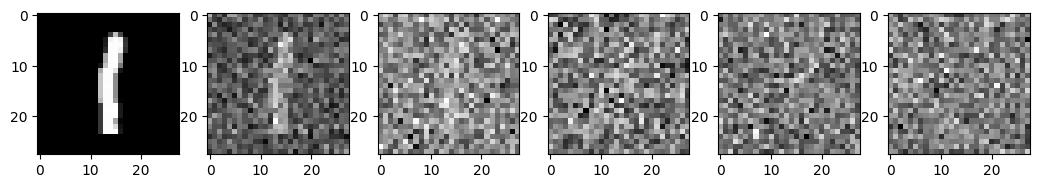

In [80]:
# Optionally, show the diffusion (forward) process
#for step, batch in enumerate(data_loader):
show_forward(model, data_loader, device)

### Show the denoising (backward) process

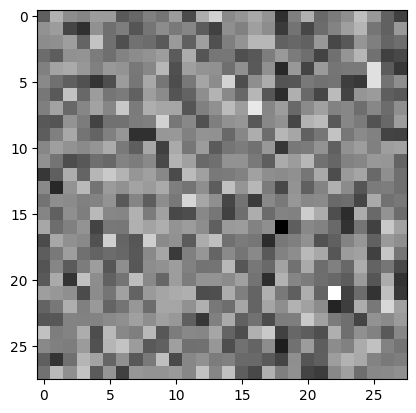

In [81]:
generated = generate_new_images(model,n_samples=1)
img = show_tensor_image(generated.detach().cpu(),False)

Epoch 0 | step 467 Loss: 0.1012786328792572 


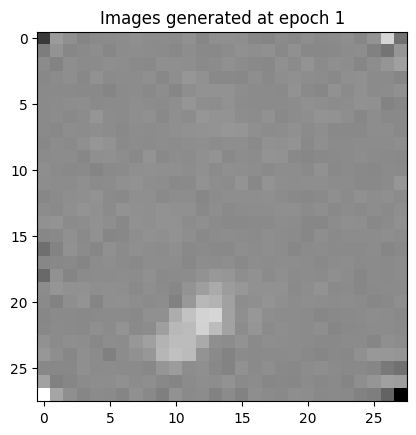

Loss at epoch 1: 0.300 --> Best model ever (stored)
Loss at epoch 2: 0.077 --> Best model ever (stored)
Loss at epoch 3: 0.061 --> Best model ever (stored)
Loss at epoch 4: 0.054 --> Best model ever (stored)
Loss at epoch 5: 0.049 --> Best model ever (stored)
Epoch 5 | step 467 Loss: 0.05017288774251938 


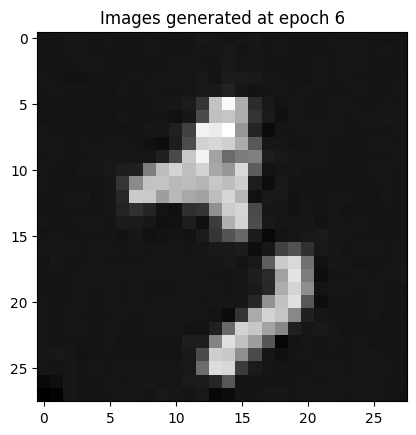

Loss at epoch 6: 0.046 --> Best model ever (stored)
Loss at epoch 7: 0.043 --> Best model ever (stored)
Loss at epoch 8: 0.042 --> Best model ever (stored)
Loss at epoch 9: 0.040 --> Best model ever (stored)
Loss at epoch 10: 0.039 --> Best model ever (stored)
Epoch 10 | step 467 Loss: 0.04447878524661064 


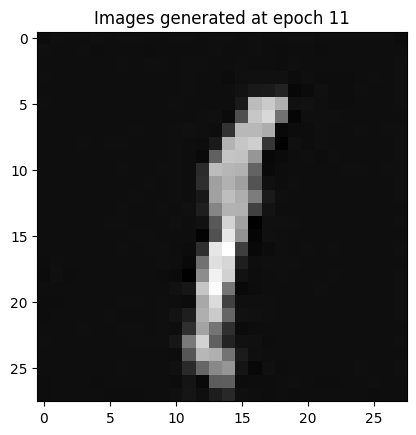

Loss at epoch 11: 0.038 --> Best model ever (stored)
Loss at epoch 12: 0.037 --> Best model ever (stored)
Loss at epoch 13: 0.037 --> Best model ever (stored)
Loss at epoch 14: 0.036 --> Best model ever (stored)
Loss at epoch 15: 0.036 --> Best model ever (stored)
Epoch 15 | step 467 Loss: 0.03928787633776665 


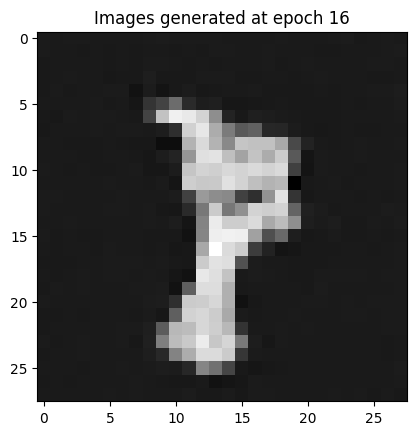

Loss at epoch 16: 0.036 --> Best model ever (stored)
Loss at epoch 17: 0.035 --> Best model ever (stored)
Loss at epoch 18: 0.034 --> Best model ever (stored)
Loss at epoch 19: 0.034 --> Best model ever (stored)
Loss at epoch 20: 0.034 --> Best model ever (stored)
Epoch 20 | step 467 Loss: 0.03232743591070175 


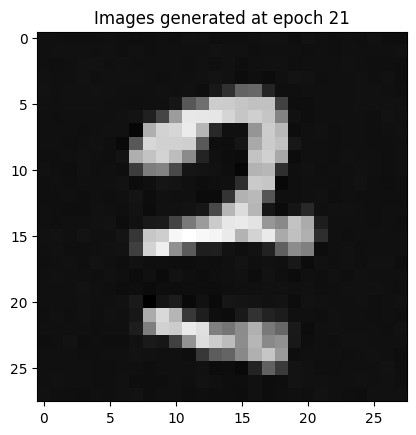

Loss at epoch 21: 0.033 --> Best model ever (stored)
Loss at epoch 22: 0.033
Loss at epoch 23: 0.033 --> Best model ever (stored)
Loss at epoch 24: 0.032 --> Best model ever (stored)
Loss at epoch 25: 0.032 --> Best model ever (stored)
Epoch 25 | step 467 Loss: 0.031643345952034 


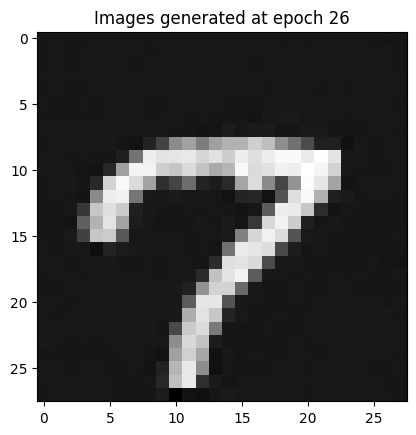

Loss at epoch 26: 0.032 --> Best model ever (stored)
Loss at epoch 27: 0.032 --> Best model ever (stored)
Loss at epoch 28: 0.031 --> Best model ever (stored)
Loss at epoch 29: 0.031 --> Best model ever (stored)
Loss at epoch 30: 0.031 --> Best model ever (stored)
Epoch 30 | step 467 Loss: 0.02793872356414795 


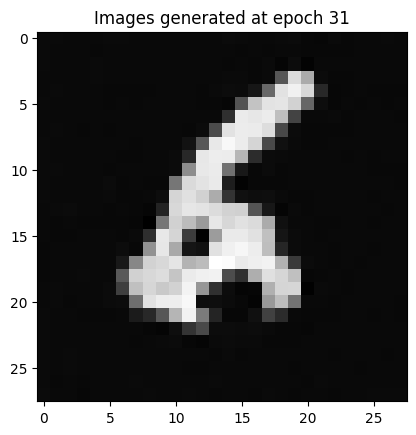

Loss at epoch 31: 0.031 --> Best model ever (stored)
Loss at epoch 32: 0.031
Loss at epoch 33: 0.031 --> Best model ever (stored)
Loss at epoch 34: 0.030 --> Best model ever (stored)
Loss at epoch 35: 0.030 --> Best model ever (stored)
Epoch 35 | step 467 Loss: 0.03353775292634964 


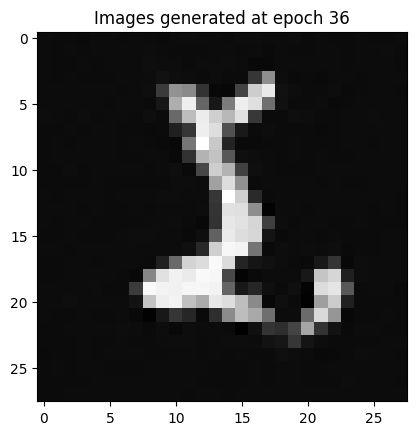

Loss at epoch 36: 0.030 --> Best model ever (stored)
Loss at epoch 37: 0.030 --> Best model ever (stored)
Loss at epoch 38: 0.030 --> Best model ever (stored)
Loss at epoch 39: 0.030
Loss at epoch 40: 0.030 --> Best model ever (stored)
Epoch 40 | step 467 Loss: 0.031960517168045044 


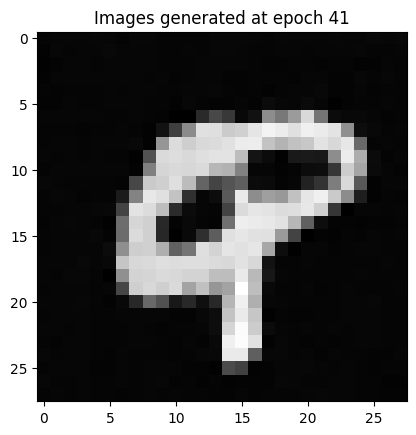

Loss at epoch 41: 0.030 --> Best model ever (stored)
Loss at epoch 42: 0.029 --> Best model ever (stored)
Loss at epoch 43: 0.029 --> Best model ever (stored)
Loss at epoch 44: 0.030
Loss at epoch 45: 0.029
Epoch 45 | step 467 Loss: 0.030935609713196754 


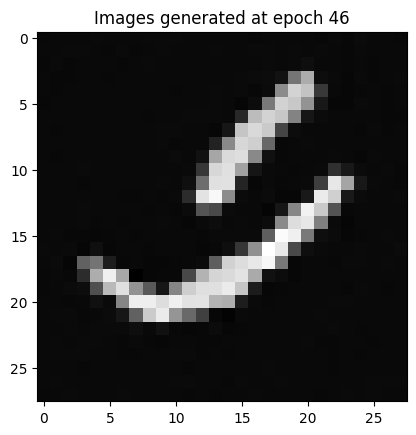

Loss at epoch 46: 0.029 --> Best model ever (stored)
Loss at epoch 47: 0.029
Loss at epoch 48: 0.029 --> Best model ever (stored)
Loss at epoch 49: 0.029
Loss at epoch 50: 0.029 --> Best model ever (stored)
Epoch 50 | step 467 Loss: 0.032082825899124146 


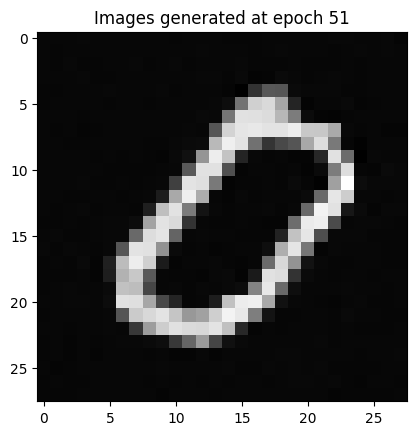

Loss at epoch 51: 0.029 --> Best model ever (stored)
Loss at epoch 52: 0.029
Loss at epoch 53: 0.029
Loss at epoch 54: 0.029 --> Best model ever (stored)
Loss at epoch 55: 0.029
Epoch 55 | step 467 Loss: 0.03225930780172348 


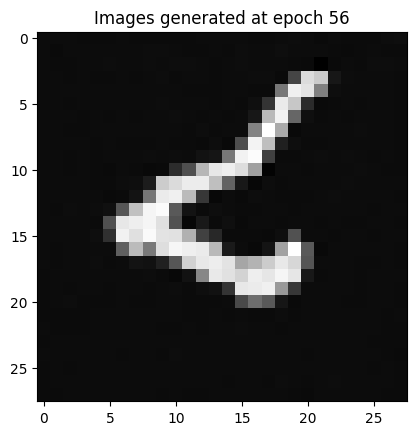

Loss at epoch 56: 0.028 --> Best model ever (stored)
Loss at epoch 57: 0.029
Loss at epoch 58: 0.028 --> Best model ever (stored)
Loss at epoch 59: 0.028
Loss at epoch 60: 0.028
Epoch 60 | step 467 Loss: 0.02732342854142189 


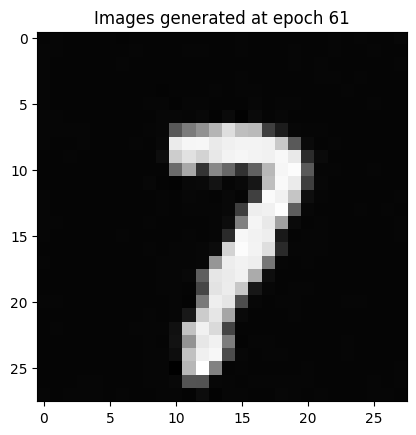

Loss at epoch 61: 0.028
Loss at epoch 62: 0.028
Loss at epoch 63: 0.028 --> Best model ever (stored)
Loss at epoch 64: 0.028
Loss at epoch 65: 0.028
Epoch 65 | step 467 Loss: 0.028188932687044144 


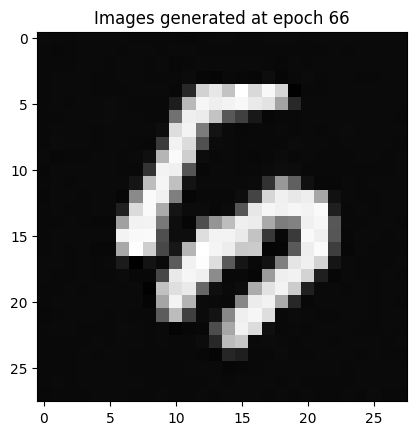

Loss at epoch 66: 0.028 --> Best model ever (stored)
Loss at epoch 67: 0.028
Loss at epoch 68: 0.028
Loss at epoch 69: 0.028
Loss at epoch 70: 0.028 --> Best model ever (stored)
Epoch 70 | step 467 Loss: 0.02726210094988346 


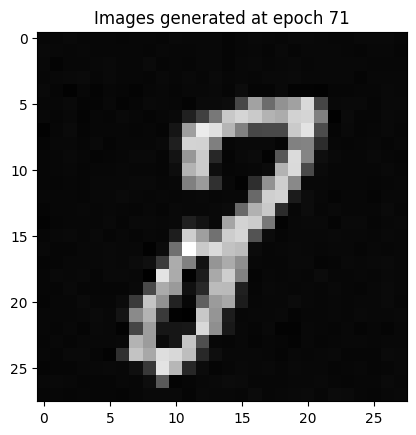

Loss at epoch 71: 0.028
Loss at epoch 72: 0.028
Loss at epoch 73: 0.028 --> Best model ever (stored)
Loss at epoch 74: 0.028 --> Best model ever (stored)
Loss at epoch 75: 0.028
Epoch 75 | step 467 Loss: 0.030974972993135452 


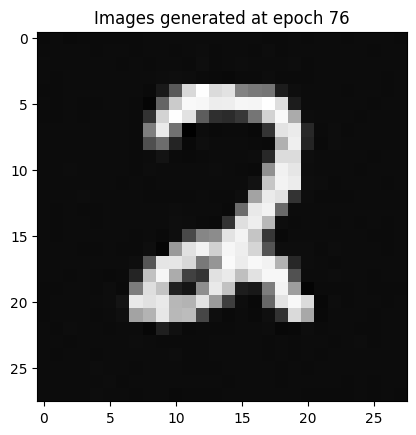

Loss at epoch 76: 0.028
Loss at epoch 77: 0.028
Loss at epoch 78: 0.028
Loss at epoch 79: 0.028
Loss at epoch 80: 0.027 --> Best model ever (stored)
Epoch 80 | step 467 Loss: 0.029246745631098747 


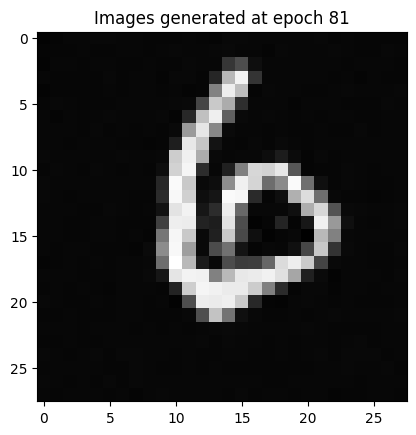

Loss at epoch 81: 0.028
Loss at epoch 82: 0.027
Loss at epoch 83: 0.028
Loss at epoch 84: 0.027
Loss at epoch 85: 0.027
Epoch 85 | step 467 Loss: 0.028905408456921577 


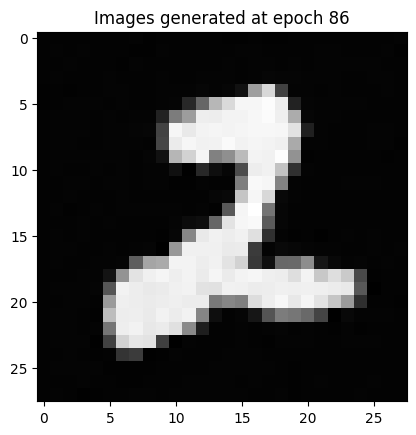

Loss at epoch 86: 0.027 --> Best model ever (stored)
Loss at epoch 87: 0.028
Loss at epoch 88: 0.028
Loss at epoch 89: 0.027 --> Best model ever (stored)
Loss at epoch 90: 0.027 --> Best model ever (stored)
Epoch 90 | step 467 Loss: 0.02499241754412651 


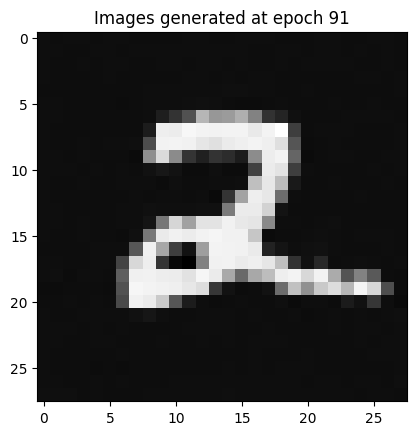

Loss at epoch 91: 0.027
Loss at epoch 92: 0.027
Loss at epoch 93: 0.027
Loss at epoch 94: 0.027
Loss at epoch 95: 0.027 --> Best model ever (stored)
Epoch 95 | step 467 Loss: 0.02793469838798046 


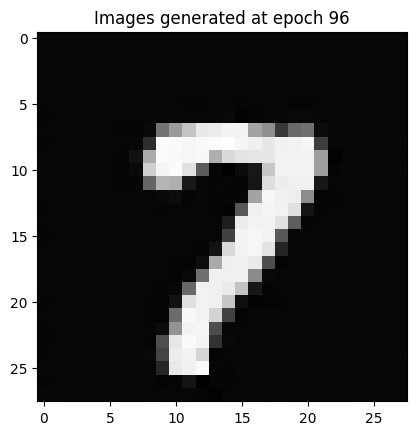

Loss at epoch 96: 0.027
Loss at epoch 97: 0.027
Loss at epoch 98: 0.027
Loss at epoch 99: 0.027 --> Best model ever (stored)
Loss at epoch 100: 0.027
Epoch 100 | step 467 Loss: 0.027996087446808815 


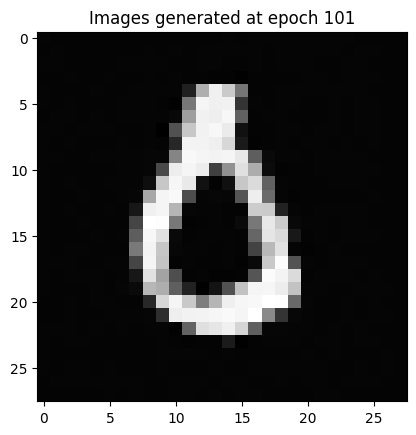

Loss at epoch 101: 0.027
Loss at epoch 102: 0.027
Loss at epoch 103: 0.027 --> Best model ever (stored)
Loss at epoch 104: 0.027
Loss at epoch 105: 0.027 --> Best model ever (stored)
Epoch 105 | step 467 Loss: 0.026308376342058182 


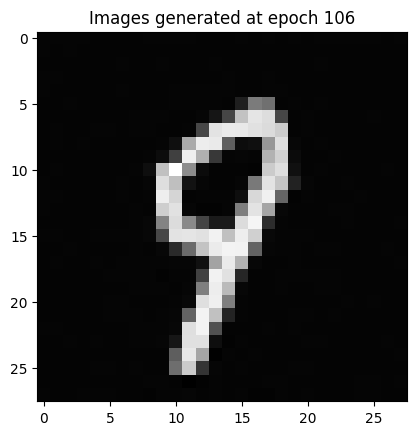

Loss at epoch 106: 0.027 --> Best model ever (stored)
Loss at epoch 107: 0.027
Loss at epoch 108: 0.027
Loss at epoch 109: 0.027 --> Best model ever (stored)
Loss at epoch 110: 0.027
Epoch 110 | step 467 Loss: 0.022303150966763496 


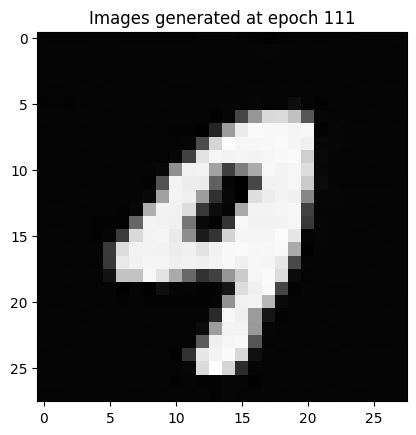

Loss at epoch 111: 0.027 --> Best model ever (stored)
Loss at epoch 112: 0.027
Loss at epoch 113: 0.027
Loss at epoch 114: 0.027
Loss at epoch 115: 0.027
Epoch 115 | step 467 Loss: 0.025708241388201714 


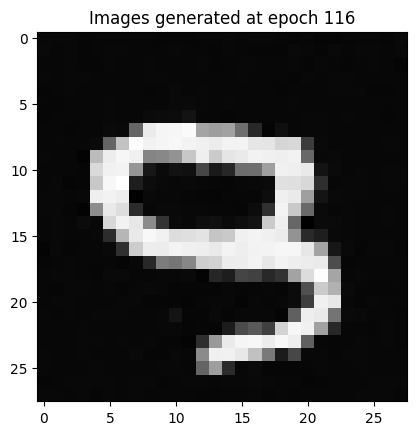

Loss at epoch 116: 0.027 --> Best model ever (stored)
Loss at epoch 117: 0.027
Loss at epoch 118: 0.027
Loss at epoch 119: 0.027
Loss at epoch 120: 0.027
Epoch 120 | step 467 Loss: 0.026871148496866226 


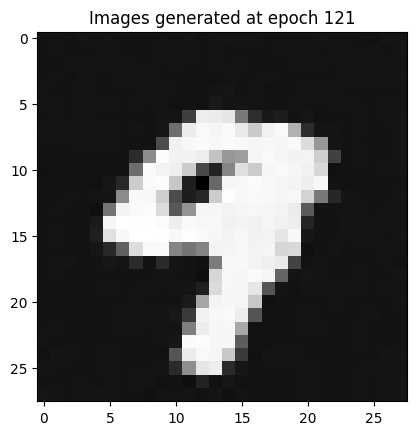

Loss at epoch 121: 0.027 --> Best model ever (stored)
Loss at epoch 122: 0.027
Loss at epoch 123: 0.027
Loss at epoch 124: 0.027
Loss at epoch 125: 0.026 --> Best model ever (stored)
Epoch 125 | step 467 Loss: 0.02230197936296463 


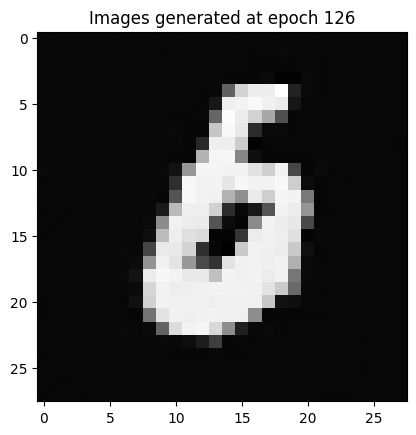

Loss at epoch 126: 0.026
Loss at epoch 127: 0.027
Loss at epoch 128: 0.026 --> Best model ever (stored)
Loss at epoch 129: 0.027
Loss at epoch 130: 0.027
Epoch 130 | step 467 Loss: 0.03096686117351055 


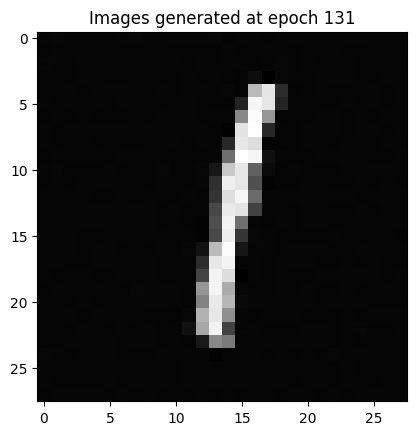

Loss at epoch 131: 0.027
Loss at epoch 132: 0.026
Loss at epoch 133: 0.027
Loss at epoch 134: 0.026
Loss at epoch 135: 0.026 --> Best model ever (stored)
Epoch 135 | step 467 Loss: 0.025386571884155273 


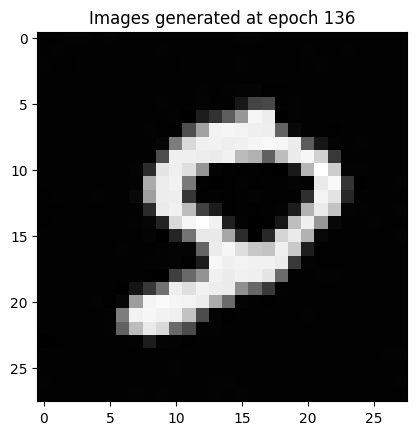

Loss at epoch 136: 0.027
Loss at epoch 137: 0.026
Loss at epoch 138: 0.026 --> Best model ever (stored)
Loss at epoch 139: 0.026
Loss at epoch 140: 0.027
Epoch 140 | step 467 Loss: 0.026423458009958267 


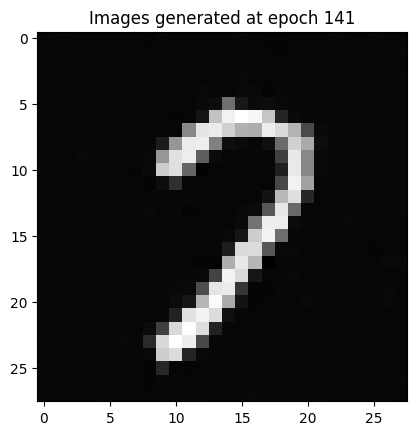

Loss at epoch 141: 0.026
Loss at epoch 142: 0.026
Loss at epoch 143: 0.026
Loss at epoch 144: 0.026
Loss at epoch 145: 0.026
Epoch 145 | step 467 Loss: 0.029598308727145195 


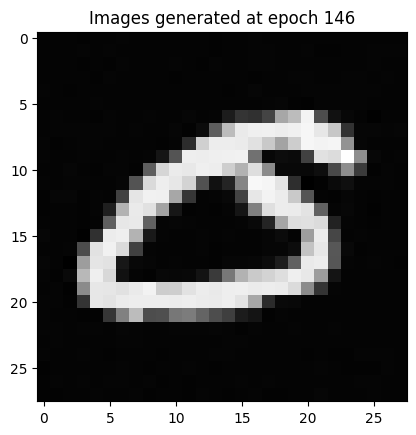

Loss at epoch 146: 0.026
Loss at epoch 147: 0.026
Loss at epoch 148: 0.026
Loss at epoch 149: 0.026
Loss at epoch 150: 0.026
Epoch 150 | step 467 Loss: 0.0256463885307312 


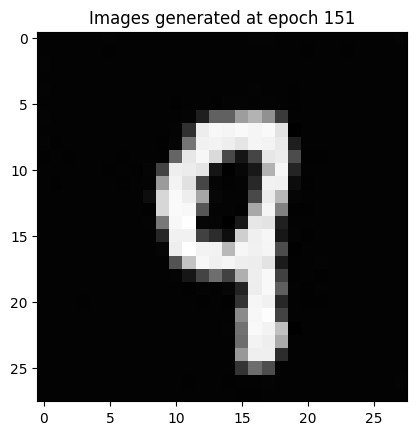

Loss at epoch 151: 0.026
Loss at epoch 152: 0.026
Loss at epoch 153: 0.026
Loss at epoch 154: 0.026
Loss at epoch 155: 0.026
Epoch 155 | step 467 Loss: 0.028868500143289566 


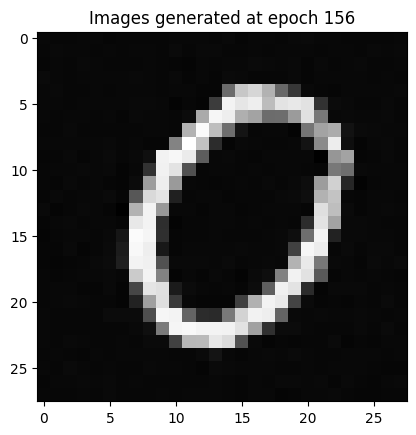

Loss at epoch 156: 0.026 --> Best model ever (stored)
Loss at epoch 157: 0.026
Loss at epoch 158: 0.026
Loss at epoch 159: 0.026
Loss at epoch 160: 0.026 --> Best model ever (stored)
Epoch 160 | step 467 Loss: 0.029507962986826897 


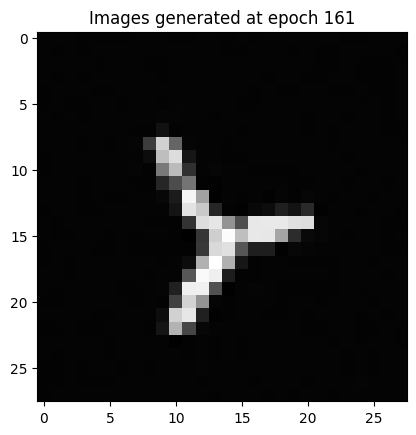

Loss at epoch 161: 0.026
Loss at epoch 162: 0.026
Loss at epoch 163: 0.026
Loss at epoch 164: 0.026
Loss at epoch 165: 0.026
Epoch 165 | step 467 Loss: 0.022621523588895798 


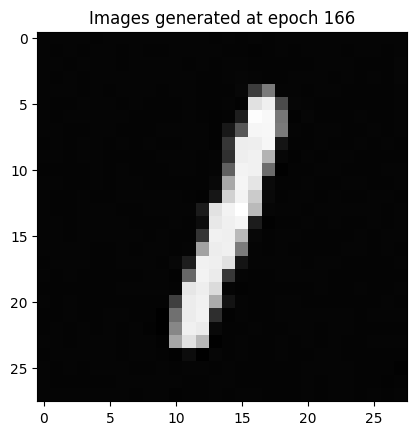

Loss at epoch 166: 0.026
Loss at epoch 167: 0.026
Loss at epoch 168: 0.026
Loss at epoch 169: 0.026
Loss at epoch 170: 0.026
Epoch 170 | step 467 Loss: 0.02652459405362606 


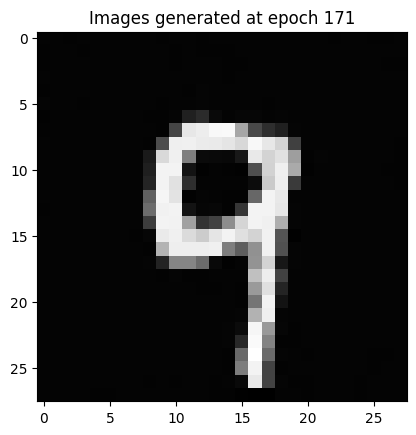

Loss at epoch 171: 0.026
Loss at epoch 172: 0.026
Loss at epoch 173: 0.026
Loss at epoch 174: 0.026 --> Best model ever (stored)
Loss at epoch 175: 0.026
Epoch 175 | step 467 Loss: 0.024097628891468048 


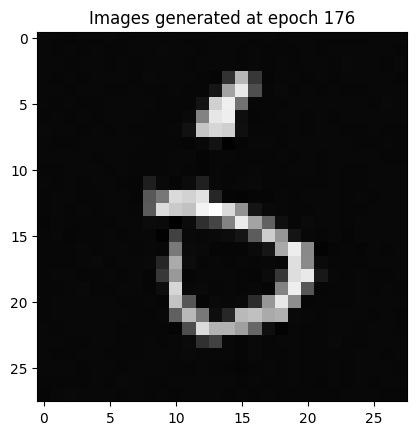

Loss at epoch 176: 0.026
Loss at epoch 177: 0.026
Loss at epoch 178: 0.026
Loss at epoch 179: 0.026
Loss at epoch 180: 0.026
Epoch 180 | step 467 Loss: 0.022656070068478584 


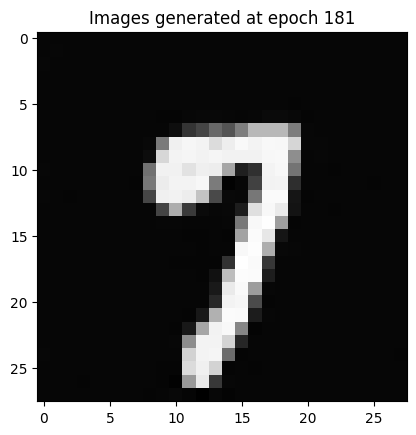

Loss at epoch 181: 0.026
Loss at epoch 182: 0.026
Loss at epoch 183: 0.026
Loss at epoch 184: 0.026 --> Best model ever (stored)
Loss at epoch 185: 0.026
Epoch 185 | step 467 Loss: 0.022304227575659752 


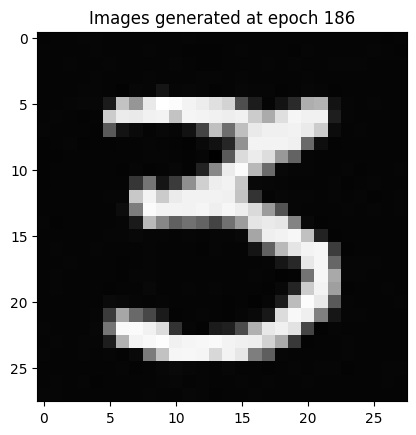

Loss at epoch 186: 0.026
Loss at epoch 187: 0.026
Loss at epoch 188: 0.026 --> Best model ever (stored)
Loss at epoch 189: 0.026
Loss at epoch 190: 0.026
Epoch 190 | step 467 Loss: 0.025570658966898918 


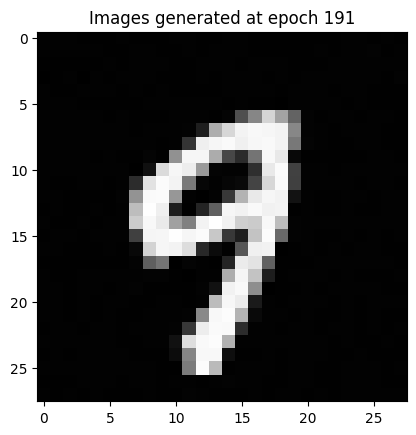

Loss at epoch 191: 0.026
Loss at epoch 192: 0.026 --> Best model ever (stored)
Loss at epoch 193: 0.026
Loss at epoch 194: 0.026
Loss at epoch 195: 0.026
Epoch 195 | step 467 Loss: 0.03248883783817291 


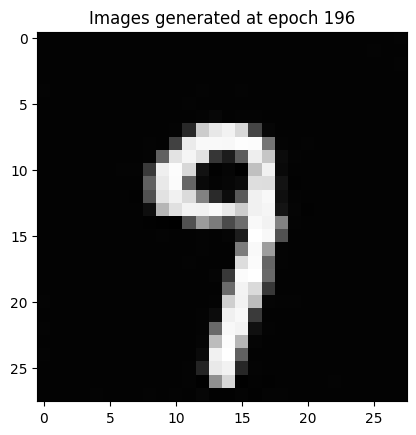

Loss at epoch 196: 0.026
Loss at epoch 197: 0.026
Loss at epoch 198: 0.026
Loss at epoch 199: 0.026
Loss at epoch 200: 0.026


In [82]:
from torch.optim import Adam
train_hist = {}
train_hist['loss'] = []
model.to(device)
optimizer = Adam(model.parameters(), lr=lr)
mse = nn.MSELoss()
best_loss = float("inf")
n_steps = model.n_steps
epochs = EPOCH # Try more!
ws_test = [0.0, 0.5, 2.0] # strength of generative guidance
for epoch in range(epochs):
    data_loader = DataLoader( train_data, batch_size=BATCH_SIZE, shuffle=True,drop_last=True )
    optimizer.param_groups[0]['lr'] = lr*(1-epoch/epochs)
    epoch_loss = 0.0
    for step, batch in enumerate(data_loader):
      optimizer.zero_grad()

      #t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      #print('batch:', batch.shape)
      x = batch.to(device)
      n = len(x)
      # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
      eta = torch.randn_like(x).to(device)
      t = torch.randint(0, n_steps, (n,)).to(device)
      # Computing the noisy image based on x0 and the time-step (forward process)
      noisy_imgs = model(x, t, eta)
      # Getting model estimation of noise based on the images and the time-step
      eta_theta = model.backward(noisy_imgs, t.reshape(n, -1))
      #print(eta_theta.shape,eta.shape)
      loss = mse(eta_theta, eta)
      train_hist['loss'].append(loss.item())
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item() * len(x) / len(data_loader.dataset)
    if epoch % 5 == 0:
      print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
      img=generate_new_images(model,n_samples=4, device=device)
      #, f"Images generated at epoch {epoch + 1}"
      show_tensor_image(img.detach().cpu(),False)
      plt.title(f"Images generated at epoch {epoch + 1}")
      plt.show()
    log_string = f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}"
    # Storing the model
    if best_loss > epoch_loss:
        best_loss = epoch_loss
        torch.save(model.state_dict(), os.path.join(save_dir, 'testing.pt'))
        log_string += " --> Best model ever (stored)"
    print(log_string)

In [85]:
torch.save(model.state_dict(), os.path.join(save_dir, '32_relu_diffusion_model_200_epoch.pt'))

## Denoising image

8


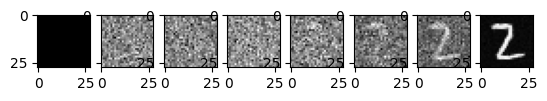

In [97]:
# Denoising
model.load_state_dict(torch.load(os.path.join(save_dir, '32_relu_diffusion_model_200_epoch.pt')))
imgs=generate_new_images(model,n_samples=1, device=device,process=True)
      #, f"Images generated at epoch {epoch + 1}"
print(len(imgs))
for idx,img in enumerate(imgs):
      plt.subplot(1, 7 + 1, idx + 1)
      show_tensor_image(img.detach().cpu(),False)

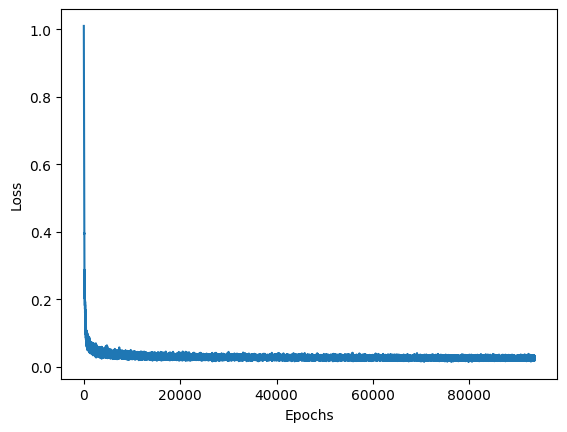

In [87]:
fig = plt.figure()
plt.plot(train_hist['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Generating Images
- Use `torch` to generate some noise as images.
- Use `torchvision.utils.save_image` to save `torch.Tensor` as an `png` image file.

Saving 00001.png
Saving 00002.png
Saving 00003.png
Saving 00004.png
Saving 00005.png
Saving 00006.png
Saving 00007.png
Saving 00008.png
Saving 00009.png
Saving 00010.png
Saving 00011.png
Saving 00012.png
Saving 00013.png
Saving 00014.png
Saving 00015.png
Saving 00016.png
Saving 00017.png
Saving 00018.png
Saving 00019.png
Saving 00020.png
Saving 00021.png
Saving 00022.png
Saving 00023.png
Saving 00024.png
Saving 00025.png
Saving 00026.png
Saving 00027.png
Saving 00028.png
Saving 00029.png
Saving 00030.png
Saving 00031.png
Saving 00032.png
Saving 00033.png
Saving 00034.png
Saving 00035.png
Saving 00036.png
Saving 00037.png
Saving 00038.png
Saving 00039.png
Saving 00040.png
Saving 00041.png
Saving 00042.png
Saving 00043.png
Saving 00044.png
Saving 00045.png
Saving 00046.png
Saving 00047.png
Saving 00048.png
Saving 00049.png
Saving 00050.png
Saving 00051.png
Saving 00052.png
Saving 00053.png
Saving 00054.png
Saving 00055.png
Saving 00056.png
Saving 00057.png
Saving 00058.png
Saving 00059.p

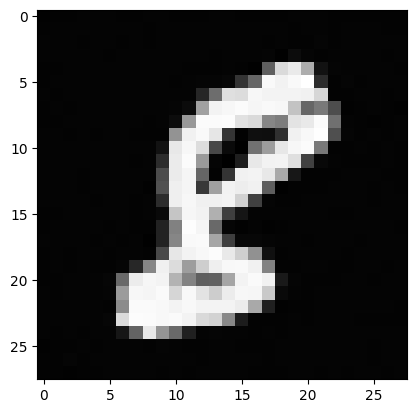

In [88]:
#model.load_state_dict(torch.load(os.path.join(save_dir, 'new_diffusion_model_100_epoch_best_29.pt')))
#model.to(device)
@torch.no_grad()
def plot_result_image():
    # Sample noise
    num_images = 10000
    os.makedirs('./images', exist_ok=True)
    for j in range(num_images):
        path = os.path.join(f'./images/{j+1:05d}.png')
        image = generate_new_images(model,n_samples=1, device=device)
        img = show_tensor_image(image.detach().cpu(),False)
        print(f'Saving {j+1:05d}.png')
        save_image(img,path,normalize=True)

plot_result_image()

## Evaluate Generated Images at Runtime
- Use `torchvision.io.read_image` to load all images into memory one by one.
- Use `pytorch_gan_metrics.get_fid` to calculate FID between generated images in `./images` and our dataset (`mnist.npz`).

    The following is the document about how to use `get_fid` for reference.
    ```python
    from pytorch_gan_metrics import get_fid

    images = ...                                    # [N, 3, H, W] normalized to [0, 1]
    FID = get_fid(images, 'path/to/statistics.npz') # Frechet Inception Distance
    ```

The output FID should be the same as Checkpoint 2 (round to two decimal places).

In [92]:
from pytorch_gan_metrics import get_fid
from torchvision.io import read_image
num_images = 10000
images = []
for i in range(num_images):
    path = os.path.join(f'./images/{i+1:05d}.png')
    image = read_image(path) / 255.
    images.append(image)
images = torch.stack(images, dim=0)
FID = get_fid(images,'./mnist.npz')
print(f'{FID:.5f}')

9.28317


---

## Use `torchvision` to Save Grid Images

In [98]:
for i in range(8):
    print('Images idx: ',i)
    imgs = generate_new_images(model,n_samples=1, device=device,process=True)
    #print(imgs.shape)
    imge=show_tensor_image(imgs.detach().cpu(),True)
    #save_image(imge,'tmp.png')
    if i == 0:
        grid_imgs=imgs
    else:
        grid_imgs=torch.cat((grid_imgs,imgs),0)
    #print(grid_imgs.shape)


Images idx:  0
Images idx:  1
Images idx:  2
Images idx:  3
Images idx:  4
Images idx:  5
Images idx:  6
Images idx:  7


In [99]:
from PIL import Image
images = []
os.makedirs('./result', exist_ok=True)
for i in range(64):
    save_image( grid_imgs[i, :, :, :] ,f'./result/tmp_{i}.png',nrow=8,normalize=True)

result_data = []
transform_result=transforms.ToTensor()
for i in range(8):
    for j in range(8):
        im_path = f'./result/tmp_{i+8*j}.png'
        x =transform_result(Image.open(im_path))
        #print(x.shape)
        result_data.append( transform_result(Image.open(im_path)))

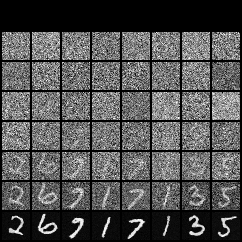

In [31]:
from IPython.display import Image, display

img = make_grid(result_data)
save_image(img,'tmp.png', normalize=True)
display(Image(filename='tmp.png'))